## Research Task - Incorporate feedback to Transit Performance Metrics Portfolio #1514

via Juan Matute
>If you're taking requests, I'd like to see the Table 8.1 performance metrics on a statewide basis, along with a 
>- list for each performance metric of which individual transit agency-mode of service combinations are 
>- in the bottom 5% (approximately two standard deviations from the mean) for each. 
>
>This would be illustrative for discussion purposes.


## Table 8.1
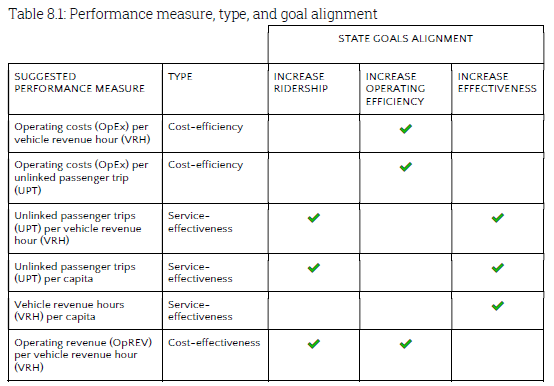

In [1]:
import altair as alt
import numpy as np
import pandas as pd
from new_transit_metrics_utils import GCS_FILE_PATH, make_long, sum_by_group

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
df = pd.read_parquet(f"{GCS_FILE_PATH}raw_transit_performance_metrics_data.parquet")

In [3]:
df.columns

Index(['agency_name', 'agency_status', 'city', 'mode', 'service', 'ntd_id',
       'reporter_type', 'reporting_module', 'state', 'primary_uza_name',
       'year', 'upt', 'vrh', 'vrm', 'opexp_total', 'RTPA', '_merge'],
      dtype='object')

In [4]:
df_agg = (
    df.groupby(["ntd_id", "city", "agency_name", "mode", "service"])
    .agg({"upt": "sum", "vrh": "sum", "vrm": "sum", "opexp_total": "sum"})
    .reset_index()
)

In [5]:
calc_dict = {
    "opex_per_vrh": ("opexp_total", "vrh"),
    "opex_per_vrm": ("opexp_total", "vrm"),
    "upt_per_vrh": ("upt", "vrh"),
    "upt_per_vrm": ("upt", "vrm"),
    "opex_per_upt": ("opexp_total", "upt"),
}

for new_col, (num, dem) in calc_dict.items():
    df_agg[new_col] = (df_agg[num] / df_agg[dem]).round(2)

# Dealing with NaN and inf values
Some of the metric calculation results in either inf or NaN values due to divide-by-zero scenarios. These values break the standard devatition calculation.

We will analyze the differences in standard deviation by filtering the data by these scenarios
1. remove rows with zeros
2. 
    1. upt_per_vrh/vrm NaN (0/0) values replaced with zero. Zero riders per revenue mile/hours still make sense. buses can still run and pick up zero passengers. highlights service ineffencies 
    2. opex_per_upt/vrm/vrh inf (#/0) values replaced with its opexp value. operating cost still exist even if nobody rides the bus. highlights cost inefficienies 
    3. opex_per_upt/vrm/vrh NaN (0/0) values replaced with zeros. not running the bus results in not picking up passengers and  zero operating cost.

In [6]:
# any rows with zero upt/vrh/vrm/opex?
no_zero_rows = df_agg[
    (df_agg["upt"] != 0)
    & (df_agg["vrh"] != 0)
    & (df_agg["vrm"] != 0)
    & (df_agg["opexp_total"] != 0)
]

In [7]:
replaced_values = df_agg.fillna(0)

# applying logic to alternate dataframe
col_list = ["opex_per_vrh", "opex_per_vrm", "opex_per_upt"]

for i in col_list:
    replaced_values[i] = replaced_values.apply(
        lambda row: row["opexp_total"] if row[i] == np.inf else row[i], axis=1
    )

In [8]:
display(len(df_agg), len(no_zero_rows), len(replaced_values))

412

401

412

In [9]:
no_zero_rows.head()

,ntd_id,city,agency_name,mode,service,upt,vrh,vrm,opexp_total,opex_per_vrh,opex_per_vrm,upt_per_vrh,upt_per_vrm,opex_per_upt
2,90003,Oakland,San Francisco Bay Area Rapid Transit District ...,Heavy Rail,Directly Operated,444622064,13166018,435132944,3978263763,302.16,9.14,33.77,1.02,8.95
3,90003,Oakland,San Francisco Bay Area Rapid Transit District ...,Hybrid Rail,Directly Operated,7104589,198797,5840831,81439438,409.66,13.94,35.74,1.22,11.46
4,90003,Oakland,San Francisco Bay Area Rapid Transit District ...,Monorail / Automated Guideway,Purchased Transportation,3369844,116589,1839575,47048789,403.54,25.58,28.90,1.83,13.96
5,90004,Bakersfield,Golden Empire Transit District (GET),Bus,Directly Operated,26828371,1581266,19970743,168768565,106.73,8.45,16.97,1.34,6.29
6,90004,Bakersfield,Golden Empire Transit District (GET),Demand Response,Directly Operated,541009,290456,4238988,25127093,86.51,5.93,1.86,0.13,46.44


In [10]:
no_zero_rows_melt = pd.melt(
    no_zero_rows,
    id_vars = ["ntd_id","city","agency_name","mode","service"],
    value_vars = ["opex_per_vrh", "opex_per_vrm", "upt_per_vrh", "upt_per_vrm", "opex_per_upt"],
    var_name= "performance_metrics",
    value_name = "metric_units",
)

no_zero_rows_melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2005 entries, 0 to 2004
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ntd_id               2005 non-null   object 
 1   city                 2005 non-null   object 
 2   agency_name          2005 non-null   object 
 3   mode                 2005 non-null   object 
 4   service              2005 non-null   object 
 5   performance_metrics  2005 non-null   object 
 6   metric_units         2005 non-null   float64
dtypes: float64(1), object(6)
memory usage: 109.8+ KB


In [11]:
no_zero_rows_melt["performance_metrics"].value_counts()

opex_per_vrh    401
opex_per_vrm    401
upt_per_vrh     401
upt_per_vrm     401
opex_per_upt    401
Name: performance_metrics, dtype: int64

## Overall Summary Statistics

In [12]:
display(no_zero_rows.columns, no_zero_rows.describe(), no_zero_rows_melt.describe())

Index(['ntd_id', 'city', 'agency_name', 'mode', 'service', 'upt', 'vrh', 'vrm',
       'opexp_total', 'opex_per_vrh', 'opex_per_vrm', 'upt_per_vrh',
       'upt_per_vrm', 'opex_per_upt'],
      dtype='object')

,upt,vrh,vrm,opexp_total,opex_per_vrh,opex_per_vrm,upt_per_vrh,upt_per_vrm,opex_per_upt
count,4.010000e+02,4.010000e+02,4.010000e+02,4.010000e+02,401.000000,401.000000,401.000000,401.000000,401.000000
mean,1.387393e+07,6.057536e+05,9.150192e+06,1.159269e+08,152.473890,11.755387,9.795536,0.785162,29.377781
std,7.571695e+07,2.197522e+06,3.244346e+07,4.824113e+08,205.996039,20.775520,13.854108,1.527742,24.157545
min,3.000000e+01,9.000000e+00,2.810000e+02,2.590000e+02,21.930000,0.520000,0.620000,0.050000,1.860000
25%,9.960300e+04,2.597900e+04,3.275160e+05,2.757428e+06,83.280000,5.960000,2.610000,0.180000,10.290000
50%,3.538580e+05,8.076900e+04,1.208917e+06,8.105467e+06,116.130000,8.580000,5.380000,0.370000,20.540000
75%,2.716278e+06,3.188760e+05,5.037198e+06,4.053515e+07,150.660000,12.000000,11.210000,0.780000,44.770000
max,1.249836e+09,3.490394e+07,4.351329e+08,6.949403e+09,2740.980000,327.640000,122.010000,18.510000,119.070000


,metric_units
count,2005.000000
mean,40.837551
std,109.153372
min,0.050000
25%,2.490000
50%,9.610000
75%,44.410000
max,2740.980000


In [13]:
# all metrics dict

all_metrics_x ={
    "bottom_upt_vrh": "upt_per_vrh",
    "bottom_upt_vrm": "upt_per_vrm",
    "bottom_opex_vrh": "opex_per_vrh",
    "bottom_opex_vrm": "opex_per_vrm",
    "bottom_opex_upt": "opex_per_upt",
}

all_metrics =[
    "upt_per_vrh",
    "upt_per_vrm",
    "opex_per_vrh",
    "opex_per_vrm",
    "opex_per_upt",
]

service_metrics_list = [
    "upt_per_vrh",
    "upt_per_vrm",
]

cost_metrics_list = [
    "opex_per_vrh",
    "opex_per_vrm",
    "opex_per_upt",
]

In [40]:
def metrics_charts(metrics_list,df):
    for i in service_metrics_list:
        display(
        f"Statewide Bar Chart for {i}",

        # bar chart
        alt.Chart(df[df["performance_metrics"]==i])
            .mark_bar()
            .encode(
                x=alt.X("agency_name:N", sort="-y"),
                y="metric_units",
                tooltip=["agency_name:N", "mode", "service", "metric_units"],
            ).properties(
                title=f"All {i}",
                width=400,  # smaller width per facet
                height=200,
            ).facet("mode:N",columns=3
            ).resolve_scale(x="independent", y="independent")
                ,

        f"Histogram Chart for {i}",
            # distribution plot
        alt.Chart(df[df["performance_metrics"]==i])
            .mark_bar()
            .encode(
                alt.X("metric_units", bin=alt.Bin(step=5)),
                y="count()",
                tooltip=["count()"],
                # row="mode"
            ).properties(
                title = f"{i} Distribution",
                width=500,  # smaller width per facet
                height=200,
            ).facet("mode:N",columns=3
            ).resolve_scale(x="independent", y="independent"),
        
            
        # f"Heatmap Chart for {i}",    
        # # heatmap
        # alt.Chart(df[df["performance_metrics"]==i])
        #     .mark_rect()
        #     .encode(
        #         y="agency_name",
        #         x="service",
        #         color="metric_units",
        #         tooltip= ["metric_units","service","agency_name"],
        #         # row= "mode",
        #     ).properties(
        #         title = f"{i} Heatmap"
        #     ).facet("mode:N",columns=6
        #     ).interactive(),
        
        f"Box plot for {i}",
        alt.Chart(df[df["performance_metrics"]==i])
            .mark_boxplot(extent="min-max")
            .encode(
                x="mode:N",
                y="metric_units:Q"
            ).properties(
                title = f"{i} Boxplot",
                width=500,  # smaller width per facet
                height=200,)
        
        )
        
        


## Statewide Service-Effectiveness Metrics

In [41]:
metrics_charts(metrics_list = service_metrics_list, df = no_zero_rows_melt)

'Statewide Bar Chart for upt_per_vrh'

alt.FacetChart(...)

'Histogram Chart for upt_per_vrh'

alt.FacetChart(...)

'Box plot for upt_per_vrh'

alt.Chart(...)

'Statewide Bar Chart for upt_per_vrm'

alt.FacetChart(...)

'Histogram Chart for upt_per_vrm'

alt.FacetChart(...)

'Box plot for upt_per_vrm'

alt.Chart(...)

## Statewide Cost-Effecticeness Metrics

In [36]:
metrics_charts(cost_metrics_list, df = no_zero_rows_melt)

'Statewide Bar Chart for upt_per_vrh'

alt.FacetChart(...)

'Histogram Chart for upt_per_vrh'

alt.FacetChart(...)

'Heatmap Chart for upt_per_vrh'

alt.FacetChart(...)

'Statewide Bar Chart for upt_per_vrm'

alt.FacetChart(...)

'Histogram Chart for upt_per_vrm'

alt.FacetChart(...)

'Heatmap Chart for upt_per_vrm'

alt.FacetChart(...)

## Bottom 5% Service-effectiveness Metrics

In [20]:
# for the service metrics, higher is better. so look for the lowest
service_metrics = {
    "bottom_upt_vrh": "upt_per_vrh",
    "bottom_upt_vrm": "upt_per_vrm",
}

lowest_service_metrics = {}

# loop to populate dict with bottom 5% of the service metrics
for k, v in service_metrics.items():
    lowest_service_metrics[k] = no_zero_rows[
        no_zero_rows[v] <= no_zero_rows[v].quantile(0.05)
    ]

In [21]:
# loop to display the bottom 5% as dataframes
for k, v in lowest_service_metrics.items():
    print(f"\n Datset: {k}. Low service metrics are bad"),

    display(
        alt.Chart(v)
        .mark_bar()
        .encode(
            x=alt.X("agency_name", sort="y"),
            y=service_metrics[k],
            tooltip=["agency_name", "mode", service_metrics[k]],
        ).properties(title= f"Bottom 5% {service_metrics[k]}", width="container"),
        
        alt.Chart(v)
        .mark_rect()
        .encode(
            x="agency_name",
            y="mode",
            color=service_metrics[k]
        ),
        
        v[
            ["agency_name", "city", "mode", "upt", "vrm", "vrh", service_metrics[k]]
        ].sort_values(by=service_metrics[k]),
    )


 Datset: bottom_upt_vrh. Low service metrics are bad


alt.Chart(...)

alt.Chart(...)

,agency_name,city,mode,upt,vrm,vrh,upt_per_vrh
308,City of Calabasas (COC) - Public Works Departm...,Calabasas,Demand Response,14523,72173,23530,0.62
135,Central Contra Costa Transit Authority (CCCTA),Concord,Bus,17041,194414,15966,1.07
400,City of Escalon - Transit Services,Escalon,Bus,5039,108377,4537,1.11
170,Livermore / Amador Valley Transit Authority (L...,Livermore,Demand Response,146318,1309504,110483,1.32
309,City of Carson - Transportation Services Division,Carson,Bus,5926,41888,4485,1.32
202,City of Union City (UCT) - Public Works,Union City,Demand Response,89614,327516,67479,1.33
374,City of West Hollywood (WEHO) - Business Devel...,West Hollywood,Demand Response,58365,218654,42857,1.36
365,City of Rosemead - Public Works,Rosemead,Demand Response,39940,209059,29108,1.37
297,City of Bell - Community Services Department,Bell,Demand Response,14658,54800,10694,1.37
267,"Paratransit, Inc.",Sacramento,Demand Response,82352,952166,60245,1.37



 Datset: bottom_upt_vrm. Low service metrics are bad


alt.Chart(...)

alt.Chart(...)

,agency_name,city,mode,upt,vrm,vrh,upt_per_vrm
258,County of Sacramento Municipal Services Agency...,Sacramento,Bus,17738,386861,12525,0.05
400,City of Escalon - Transit Services,Escalon,Bus,5039,108377,4537,0.05
394,Stanislaus Council of Governments (StanCOG) - ...,Modesto,Vanpool,52346,716703,14815,0.07
96,Riverside Transit Agency (RTA),Riverside,Demand Response Taxi,25173,375038,13916,0.07
272,Imperial County Transportation Commission (ICTC),El Centro,Demand Response,126728,1562787,70560,0.08
151,City of Visalia (VT) - Transportation,Visalia,Commuter Bus,125615,1498297,39238,0.08
95,Riverside Transit Agency (RTA),Riverside,Demand Response,8271,98596,4036,0.08
149,Yolo County Transportation District (YCTD),Woodland,Demand Response,144189,1851119,104691,0.08
139,SunLine Transit Agency,Thousand Palms,Vanpool,110958,1357521,25333,0.08
228,County of Placer (PCT/TART) - Department of Pu...,Auburn,Bus,35604,415604,24827,0.09


## Bottom 5% Cost-effectiveness metrics

In [22]:
# for cost metrics, lower is better. so look for the highest
cost_metrics = {
    "bottom_opex_vrh": "opex_per_vrh",
    "bottom_opex_vrm": "opex_per_vrm",
    "bottom_opex_upt": "opex_per_upt",
}

highest_cost_metrics = {}

# loop to populate cost metrics dict, filters for greater than the 95th percentile (top 5% of the highest cost-metrics aka the top 5% worst cost-metrics)
for k, v in cost_metrics.items():
    highest_cost_metrics[k] = no_zero_rows[
        no_zero_rows[v] >= no_zero_rows[v].quantile(0.95)
    ]

In [29]:
# loop to display cost metrics DFs
for k, v in highest_cost_metrics.items():
    print(f"\n Datset: {k}. High cost metrics are bad"),
    display(
        alt.Chart(
            v#.sort_values(by=cost_metrics[k])
        )
        .mark_bar()
        .encode(
            x=alt.X(
                "agency_name", 
                sort="-y",
                scale=alt.Scale(paddingInner=0.1, paddingOuter=0.1),
                
            ),
            y=alt.Y(
                cost_metrics[k], 
                #stack = None
            ),
            #color= "mode",
            #xOffset="mode",
            tooltip=["agency_name", "mode", cost_metrics[k]],
        ).properties(title= f"Bottom 5% {cost_metrics[k]}",width="container"
                    ).facet(alt.Facet("mode", columns=3))
        ,
        
        alt.Chart(v)
        .mark_rect()
        .encode(
            x="agency_name",
            y="mode",
            color=cost_metrics[k]
        ),
        v[
            [
                "agency_name",
                "city",
                "mode",
                # "upt",
                "opexp_total",
                "vrm",
                "vrh",
                cost_metrics[k],
            ]
        ].sort_values(by=cost_metrics[k], ascending=False)
    )


 Datset: bottom_opex_vrh. High cost metrics are bad


SchemaValidationError: `Facet` has no parameter named 'columns'

Existing parameter names are:
shorthand      bin       field     timeUnit   
aggregate      bounds    header    title      
align          center    sort      type       
bandPosition   columns   spacing              

See the help for `Facet` to read the full description of these parameters

alt.FacetChart(...)

alt.Chart(...)

,agency_name,city,mode,opexp_total,vrm,vrh,opex_per_vrh
55,"Golden Gate Bridge, Highway and Transportation...",San Francisco,Ferryboats,195371304,948061,71278,2740.98
270,San Francisco Bay Area Water Emergency Transpo...,San Francisco,Ferryboats,244756382,2324550,114069,2145.69
88,North County Transit District (NCTD),Oceanside,Hybrid Rail,30335703,636450,28923,1048.84
225,Altamont Corridor Express (ACE),Stockton,Commuter Rail,143295615,5573755,141171,1015.05
383,Sonoma-Marin Area Rail Transit District (SMART),Petaluma,Commuter Rail,163266006,4566095,176553,924.74
184,Southern California Regional Rail Authority (S...,Los Angeles,Commuter Rail,1475810477,72782609,1996532,739.19
85,North County Transit District (NCTD),Oceanside,Commuter Rail,36665200,1682633,52108,703.64
89,North County Transit District (NCTD),Oceanside,Hybrid Rail,115328092,3606463,164336,701.78
167,Peninsula Corridor Joint Powers Board (PCJPB),San Carlos,Commuter Rail,857551415,40264769,1243871,689.42
48,City and County of San Francisco (SFMTA) - Tra...,San Francisco,Cable Car,373274268,1139285,551837,676.42



 Datset: bottom_opex_vrm. High cost metrics are bad


SchemaValidationError: `Facet` has no parameter named 'columns'

Existing parameter names are:
shorthand      bin       field     timeUnit   
aggregate      bounds    header    title      
align          center    sort      type       
bandPosition   columns   spacing              

See the help for `Facet` to read the full description of these parameters

alt.FacetChart(...)

alt.Chart(...)

,agency_name,city,mode,opexp_total,vrm,vrh,opex_per_vrm
48,City and County of San Francisco (SFMTA) - Tra...,San Francisco,Cable Car,373274268,1139285,551837,327.64
55,"Golden Gate Bridge, Highway and Transportation...",San Francisco,Ferryboats,195371304,948061,71278,206.07
270,San Francisco Bay Area Water Emergency Transpo...,San Francisco,Ferryboats,244756382,2324550,114069,105.29
51,City and County of San Francisco (SFMTA) - Tra...,San Francisco,Streetcar,168319935,1845668,364561,91.20
88,North County Transit District (NCTD),Oceanside,Hybrid Rail,30335703,636450,28923,47.66
50,City and County of San Francisco (SFMTA) - Tra...,San Francisco,Light Rail,1186464838,25477828,2818225,46.57
40,Santa Clara Valley Transportation Authority (VTA),San Jose,Light Rail,732564335,17360305,1201700,42.20
52,City and County of San Francisco (SFMTA) - Tra...,San Francisco,Trolleybus,1082916887,26990327,4379827,40.12
383,Sonoma-Marin Area Rail Transit District (SMART),Petaluma,Commuter Rail,163266006,4566095,176553,35.76
89,North County Transit District (NCTD),Oceanside,Hybrid Rail,115328092,3606463,164336,31.98



 Datset: bottom_opex_upt. High cost metrics are bad


SchemaValidationError: `Facet` has no parameter named 'columns'

Existing parameter names are:
shorthand      bin       field     timeUnit   
aggregate      bounds    header    title      
align          center    sort      type       
bandPosition   columns   spacing              

See the help for `Facet` to read the full description of these parameters

alt.FacetChart(...)

alt.Chart(...)

,agency_name,city,mode,opexp_total,vrm,vrh,opex_per_upt
258,County of Sacramento Municipal Services Agency...,Sacramento,Bus,2111992,386861,12525,119.07
400,City of Escalon - Transit Services,Escalon,Bus,561996,108377,4537,111.53
30,San Joaquin Regional Transit District (RTD),Stockton,Demand Response,6429192,698046,37354,106.91
118,City of Commerce (CCT) - Transportation,Commerce,Demand Response,5193408,391408,37970,99.16
352,City of Malibu - Community Services Department,Malibu,Demand Response,352215,33085,1717,96.60
363,City of Pico Rivera - Transit Division/Parks a...,Pico Rivera,Demand Response,2757428,88212,10848,96.55
309,City of Carson - Transportation Services Division,Carson,Bus,565380,41888,4485,95.41
135,Central Contra Costa Transit Authority (CCCTA),Concord,Bus,1613133,194414,15966,94.66
247,City of Elk Grove(etran),Elk Grove,Demand Response,6020046,501492,45410,91.47
249,San Luis Obispo Regional Transit Authority (SL...,San Luis Obispo,Demand Response,22220249,2246041,154069,88.72


In [24]:
no_zero_rows.columns

Index(['ntd_id', 'city', 'agency_name', 'mode', 'service', 'upt', 'vrh', 'vrm',
       'opexp_total', 'opex_per_vrh', 'opex_per_vrm', 'upt_per_vrh',
       'upt_per_vrm', 'opex_per_upt'],
      dtype='object')

In [25]:
alt.Chart(no_zero_rows).transform_fold(
    ['opex_per_vrh', 'opex_per_vrm', 'upt_per_vrh','upt_per_vrm', 'opex_per_upt'], as_= ["Performance Metric", "Value"]
    ).mark_bar(
        opacity = 0.3,
        binSpacing=0
    ).encode(
        alt.X("Value:Q").bin(maxbins=10),
        alt.Y("count()").stack(None),
        alt.Color("Performance Metric:N")
    )

alt.Chart(...)

In [26]:
for i in calc_dict.keys():
    display(
        alt.Chart(no_zero_rows).mark_bar().encode(
            alt.X(i).bin(maxbins=100),
            y="count()",
            tooltip=["count()"]
        ).properties(title = i),
        
       #  alt.Chart(no_zero_rows).transform_fold(
       #      ['opex_per_vrh', 'opex_per_vrm', 'upt_per_vrh',
       # 'upt_per_vrm', 'opex_per_upt'], as_=["Performance Metric", "Value"]
       #  ).mark_bar(
       #      opacity = 0.3,
       #      binSpacing=0
       #  ).encode(
       #      alt.X("Value:Q").bin(maxbins=100),
       #      alt.Y("count()").stack(None),
       #      alt.Color("Performance Metrics:N")
       #  ),
        
        alt.Chart(no_zero_rows).mark_rect().encode(
        x="agency_name",
        y="mode",
        color = i,)
        .properties(title = i),
            )

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

---

In [27]:
# who are are bottom 5% in each metrics
bottom_metrics = {
    "bottom_opex_vrh": "opex_per_vrh",
    "bottom_opex_vrm": "opex_per_vrm",
    "bottom_opex_upt": "opex_per_upt",
    "bottom_upt_vrh": "upt_per_vrh",
    "bottom_upt_vrm": "upt_per_vrm",
}
bottom_5 = {}
for k, v in bottom_metrics.items():
    bottom_5[k] = no_zero_rows[no_zero_rows[v] <= no_zero_rows[v].quantile(0.05)]

In [ ]:
for k, v in bottom_5.items():
    print(f"\n Datset: {k}"),
    display(
        v[
            [
                "agency_name",
                "mode",
                "upt",
                "vrm",
                "vrh",
                "opexp_total",
                bottom_metrics[k],
            ]
        ].sort_values(by=bottom_metrics[k])
    )